In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.9.0+cpu
0.24.0+cpu


In [2]:
train_data= datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100.0%
100.0%
100.0%
100.0%


In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [7]:
image, label = train_data[0]
image.dtype, label

(torch.float32, 9)

In [8]:
class_names = train_data.classes
classes_idx = train_data.class_to_idx
classes_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [10]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [11]:
# Check the shape of our image
print(f"Image shape {image.shape} -> [C, H, W]")
print(f"Image label: {class_names[label]}")

Image shape torch.Size([1, 28, 28]) -> [C, H, W]
Image label: Ankle boot


## Visualizing our data

In [12]:
import matplotlib.pyplot as plt

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

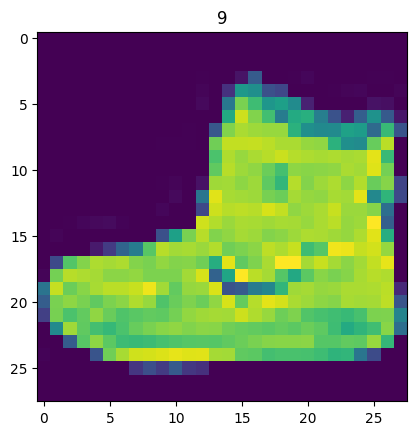

In [13]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label)

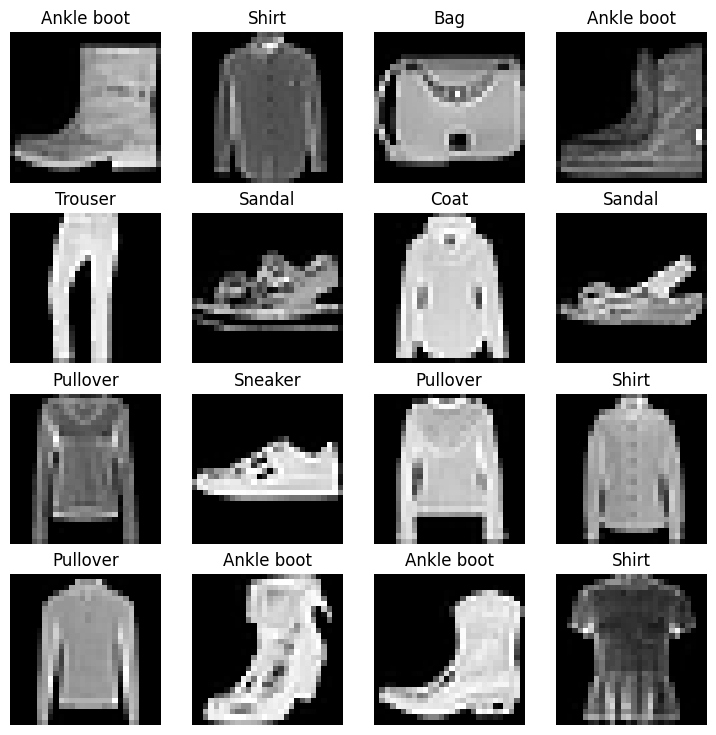

In [14]:
# Plot more images

torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [15]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## Prepare DataLoader

In [16]:
from torch.utils.data import DataLoader

# setup the batch size
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1fd91cf7e00>,
 <torch.utils.data.dataloader.DataLoader at 0x1fd96e725d0>)

In [17]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of the train_dataloader: {len(train_dataloader)}, batches of size: {BATCH_SIZE}")
print(f"Length of the test-dataloader: {len(test_dataloader)}, batches of size: {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001FD91CF7E00>, <torch.utils.data.dataloader.DataLoader object at 0x000001FD96E725D0>)
Length of the train_dataloader: 1875, batches of size: 32
Length of the test-dataloader: 313, batches of size: 32


In [18]:
# Check out what's inside the training dataloader

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
label: 6, label size: torch.Size([])


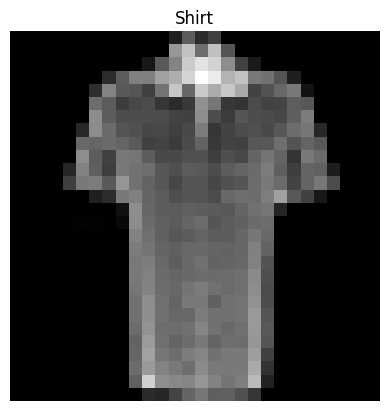

In [19]:
# Show a sample

torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=(1,)).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"label: {label}, label size: {label.shape}")

## Building a Convolutional Neural Network (CNN)

In [20]:
## Conv net (TinyVGG architechture)

class FashionMNISTModel(nn.Module):
  """
  Model architechture that replicates a TinyVGG
  model from CNN explainer website
  """
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Create a conv layer
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*49,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    #print(f"Output shape of classifier layer: {x.shape}")
    return x

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [23]:
torch.manual_seed(42)
model = FashionMNISTModel(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

### Set up loss & optimizer functions

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

In [25]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 91.29
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Set up train & test functions

In [26]:
# Make a function to measure the time of training

from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """ Prints diffrence between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [27]:
start_time = timer()
 # some code...
end_time = timer()
print_train_time(start=start_time,
                 end=end_time,
                 device="cpu")

Train time on cpu: 0.001 seconds


0.0005625999765470624

In [29]:
# FUnction for train loop

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model and data_loader."""
  train_loss, train_acc = 0, 0
  model.to(device)

  # Set model into training mode
  model.train()

  # Loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass (outputs the raw logits from the model)
    y_pred = model(X)

    # 2. Calculate loss per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulating train loss of every batch
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) # go from logits -> pred labels

    # 3. Optimizer.zero_grad()
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (updates the model's parameters per each batch)
    optimizer.step()


  # Divide total train loss and accuracy by length of dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f}, Train accuracy: {train_acc:.2f}%")

In [34]:
# Function for test loop
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over dataloader."""
  test_loss, test_acc = 0, 0
  model.to(device)
  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (outputs raw logits)
      test_pred = model(X)

      # 2. Calculate the loss/accuracy
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits to pred labels

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%\n")

In [30]:
# function for evaluating the model
from tqdm.auto import tqdm

torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make our data device-agnostic
      X, y = X.to(device), y.to(device)
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                      y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss, acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # This only works when the model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

c:\Users\eltso\FMNIST_classifier_model_0\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Train & test the model

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

  train_time_end = timer()
  total_train_time = print_train_time(start=train_time_start,
                                              end=train_time_end,
                                              device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.35984, Train accuracy: 87.02%


 33%|███▎      | 1/3 [00:46<01:33, 46.73s/it]

Test loss: 0.35620, Test accuracy: 87.72%

Train time on cpu: 46.735 seconds
Epoch: 1
-------
Train loss: 0.32326, Train accuracy: 88.28%


 67%|██████▋   | 2/3 [01:33<00:46, 46.86s/it]

Test loss: 0.34190, Test accuracy: 87.64%

Train time on cpu: 93.693 seconds
Epoch: 2
-------
Train loss: 0.30277, Train accuracy: 88.98%


100%|██████████| 3/3 [02:20<00:00, 46.74s/it]

Test loss: 0.30441, Test accuracy: 88.92%

Train time on cpu: 140.230 seconds


In [54]:
# Get model results
model_results = eval_model(model=model,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_results

100%|██████████| 313/313 [00:04<00:00, 73.13it/s]


{'model_name': 'FashionMNISTModel',
 'model_loss': 0.30441126227378845,
 'model_acc': 88.91773162939297}

## Model prediction and evaluation

In [41]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Going from logits to prediction probabilities
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [37]:
img, label = test_data[0][:10]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [38]:
import random
#random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Bag')

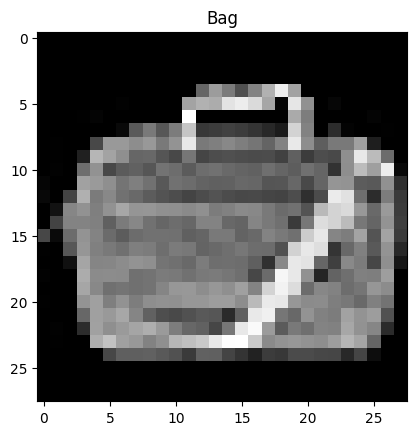

In [39]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [42]:
# Make predictions
pred_probs = make_predictions(model=model,
                              data=test_samples)

# View first two prediction probabilities
pred_probs[:2]

tensor([[3.0845e-03, 5.2544e-05, 3.2109e-03, 4.9406e-05, 4.9903e-02, 9.9873e-05,
         7.8487e-03, 4.2950e-04, 9.3511e-01, 2.0842e-04],
        [3.2570e-03, 3.5611e-05, 9.4432e-04, 2.1411e-03, 2.1602e-02, 6.1457e-05,
         9.7156e-01, 4.3124e-07, 3.9880e-04, 1.6644e-06]])

In [43]:
# Convert prediction probabilities into labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 6, 7, 1, 6, 0, 1, 0, 6])

In [44]:
test_labels

[8, 6, 7, 1, 6, 6, 1, 0, 0]

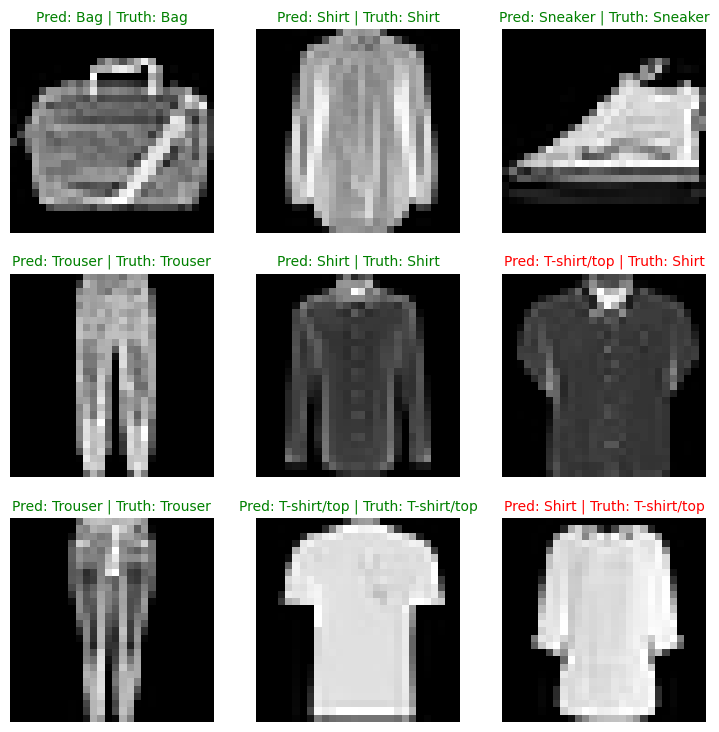

In [45]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g "Dress")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label in text form
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Chech for equatily between pred and truth and change the color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

### Making predictions with traiined model

In [46]:
# Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to tagret device
    X, y = X.to(device), y.to(device)

    # Do the forward pass
    y_logit = model(X)

    #Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
#print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...: 100%|██████████| 313/313 [00:04<00:00, 72.10it/s]


tensor([9, 2, 1,  ..., 8, 1, 2])

In [47]:
len(y_pred_tensor)

10000

### Plot confusion matrix

In [48]:
import mlxtend
assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"

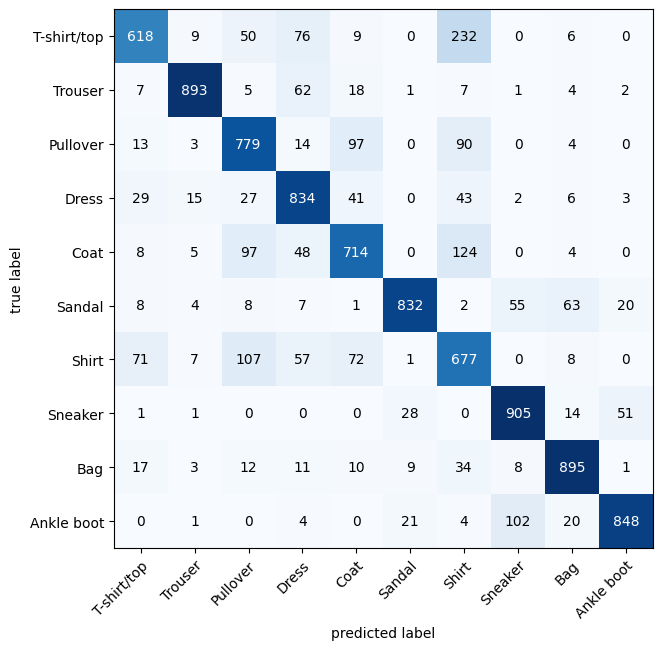

In [49]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup a confusion matrix and compare predictions to targets
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10, 7)
)

## Save and load the model

In [51]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("trained_models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)


# Create model save path
MODEL_NAME = "FMNIST_pytorch_cnn_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: trained_models\FMNIST_pytorch_cnn_model.pth


In [52]:
# Create a new instance
torch.manual_seed(42)

loaded_model = FashionMNISTModel(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model.to(device)

FashionMNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [56]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_results = eval_model(
    model=loaded_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_results

100%|██████████| 313/313 [00:04<00:00, 77.22it/s]


{'model_name': 'FashionMNISTModel',
 'model_loss': 0.30441126227378845,
 'model_acc': 88.91773162939297}

In [57]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_results["model_loss"]),
              torch.tensor(loaded_model_results["model_loss"]),
              atol=1e-02)

tensor(True)